# Experiment 1: Various Active Learning Methods
This notebook shows the experiments for running each active learning method. The experiments use a CNNVAE embedding on MSTAR and zero-shot transfer learning on the other datasets. The underyling acquisition function is uncertainty in each case. This corresponds to the "Time consumption and accuracy comparison experiment among different active learning sampling methods" experiment in the paper. The bottom of this document also contains the detailed plots of these experiments (over time). 

Methods:
- LocalMax
- Random
- TopMax
- Acq_Sample
- Sequential

Datasets:
- MSTAR
- OpenSARShip
- FUSAR-Ship

In [1]:
#Check the GPU and RAM
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Sun Jan  8 04:09:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    51W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#Mount drive and install python packages
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('drive/MyDrive/SAR_BAL')

Mounted at /content/drive


In [3]:
!pip install graphlearning annoy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 KB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.0/648.0 KB 43.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for graphlearning: filename=graphlearning-1.2.1-cp38-cp38-linux_x86_64.whl size=143756 sha256=06a97ec63202d72392797c5aeeac34b471f6e782e7ddd95490f201cc464a1e89
  Stored in directory: /root/.cache/pip/wheels/5e/84/62/681cf2c2a59f1f5e58d52fb110e2eb4c93c9c808d932829543
  Created wheel for annoy: filename=annoy-1.17.1-cp38-cp38-linux_x86_64.whl size=396902 sha256=c2712c114f965514f01340c9e29e578daa141193824179fb75864f991be0325c
  Stored in directory: /root/.cache/pip/wheels/f9/93/19/30511c4a9ae6b4937455a134c34a39e13943e2c6f46fcd2ed2
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any

In [4]:
import pandas as pd

from experiments import experiment_1, experiment_1_simple_plotter, experiment_1_full_save, EXPERIMENT_1_SAVE_PATH
from models import CVAE

## Parameters

In [5]:
#Non-default Parameters

HARDWARE_ACCELERATION = True
acq_fun_list = ['uc']

## Experiments

In [6]:
acc_mstar, time_mstar, num_labels_mstar, full_acc_mstar = experiment_1(
    'mstar', 
    hardware_acceleration=HARDWARE_ACCELERATION,
)

Using pre-computed cnnvae embedding knn_data


In [7]:
acc_open_sar, time_open_sar, num_labels_open_sar, full_acc_open_sar = experiment_1(
    'open_sar_ship',
    hardware_acceleration=HARDWARE_ACCELERATION,
)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [8]:
acc_fusar, time_fusar, num_labels_fusar, full_acc_fusar = experiment_1(
    'fusar',
    hardware_acceleration=HARDWARE_ACCELERATION,
)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X0_5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth


  0%|          | 0.00/5.28M [00:00<?, ?B/s]

## Accuracy Results

In [9]:
#Create pandas dataframe
acc_results = {'mstar': acc_mstar, 'open_sar_ship': acc_open_sar, 'fusar': acc_fusar}
df_acc = pd.DataFrame.from_dict(acc_results, orient='index')

#Save
df_acc.to_pickle(EXPERIMENT_1_SAVE_PATH + 'Pickles/accuracy_table.pkl')

#Display data
print("Accuracy")
print(df_acc)

Accuracy
               local_max     random   topn_max  acq_sample  global_max
mstar          99.691939  92.657881  99.691939   96.269040   99.931542
open_sar_ship  81.245814  71.600804  80.643001   73.342264   81.647689
fusar          89.832690  68.725869  85.585586   72.715573   89.189189


## Time Results

In [10]:
#Create pandas dataframe
time_results = {'mstar': time_mstar, 'open_sar_ship': time_open_sar, 'fusar': time_fusar}
df_time = pd.DataFrame.from_dict(time_results, orient='index')

#Save
df_time.to_pickle(EXPERIMENT_1_SAVE_PATH + 'Pickles/time_table.pkl')

#Display data
print("Time")
print(df_time)

Time
               local_max     random   topn_max  acq_sample  global_max
mstar          26.699693  24.172801  25.963318   26.712425  338.106096
open_sar_ship   5.331493   4.682193   4.861012    4.858958   47.433218
fusar          26.798513  21.205896  26.076811   21.552674  322.993112


## MSTAR Detailed Plots

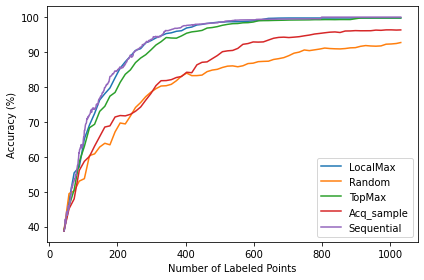

In [11]:
experiment_1_simple_plotter(num_labels_mstar, full_acc_mstar, dataset='mstar')

## OpenSARShip Detailed Plots

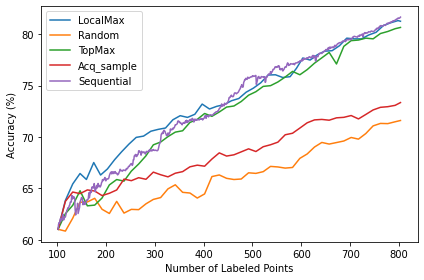

In [12]:
experiment_1_simple_plotter(num_labels_open_sar, full_acc_open_sar, dataset='open_sar_ship')

## FUSAR-Ship Detailed Plots

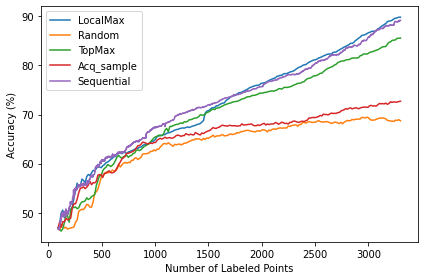

In [13]:
experiment_1_simple_plotter(num_labels_fusar, full_acc_fusar, dataset='fusar')

## Saving Plots with SoTA

MSTAR


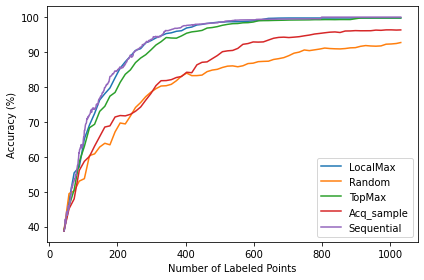

OpenSARShip


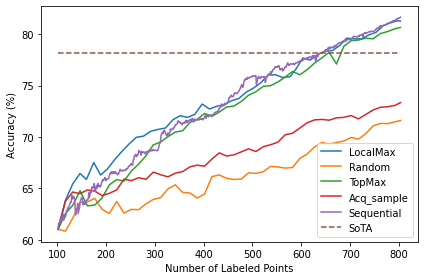

FUSAR-Ship


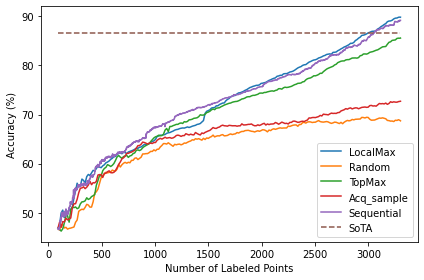

In [14]:
print("MSTAR")
experiment_1_simple_plotter(num_labels_mstar, full_acc_mstar, dataset='mstar', include_sota=True)

print("OpenSARShip")
experiment_1_simple_plotter(num_labels_open_sar, full_acc_open_sar, dataset='open_sar_ship', include_sota=True)

print("FUSAR-Ship")
experiment_1_simple_plotter(num_labels_fusar, full_acc_fusar, dataset='fusar', include_sota=True)

## Save All Data

In [15]:
#MSTAR
experiment_1_full_save(acc_mstar, time_mstar, num_labels_mstar, full_acc_mstar, 'mstar')

#OpenSARShip
experiment_1_full_save(acc_open_sar, time_open_sar, num_labels_open_sar, full_acc_open_sar, 'open_sar_ship')

#FUSAR-Ship
experiment_1_full_save(acc_fusar, time_fusar, num_labels_fusar, full_acc_fusar, 'fusar')

Saving to: Experiment Results/Experiment 1/Pickles/
Saving to: Experiment Results/Experiment 1/Pickles/
Saving to: Experiment Results/Experiment 1/Pickles/
